<a href="https://colab.research.google.com/github/ewokdanceparty/spikeMatcher/blob/main/spikeMatcher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import os.path
from os import path

if not path.exists("data"):
  !mkdir data

if not path.exists("data/time_series.csv"):
  !wget -P data https://raw.githubusercontent.com/ewokdanceparty/spikeMatcher/main/data/time_series.csv

if not path.exists("data/spike_info.csv"):
  !wget -P data https://raw.githubusercontent.com/ewokdanceparty/spikeMatcher/main/data/spike_info.csv

import pandas as pd
pd.plotting.register_matplotlib_converters()
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
print('Setup complete')

--2021-12-07 20:13:44--  https://raw.githubusercontent.com/ewokdanceparty/spikeMatcher/main/data/time_series.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36666616 (35M) [text/plain]
Saving to: ‘data/time_series.csv’

time_series.csv     100%[===================>]  34.97M   157MB/s    in 0.2s    

2021-12-07 20:13:45 (157 MB/s) - ‘data/time_series.csv’ saved [36666616/36666616]

--2021-12-07 20:13:45--  https://raw.githubusercontent.com/ewokdanceparty/spikeMatcher/main/data/spike_info.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200

In [8]:
time_series_path = 'data/time_series.csv'
time_series_pd = pd.read_csv(time_series_path, header=None, dtype='single')
#print(time_series_pd.describe())
#print(time_series_pd.head)
time_series_np = time_series_pd.to_numpy().ravel()
#print(time_series_np.shape)
print('Done loading the electrode data')

Done loading the electrode data


### The extracellular voltage (voltage outside a neuron) contains spikes from several neurons in the vicinity of the electrode. How do we know which spikes originated from which neurons? This is known as "spike sorting," and there are a lot of approaches to it. Something that helps is that a given neuron at a given distance from an electrode will tend to have a similar spike amplitude and shape. There are exceptions, such as when some types of neurons fire a "burst" of spikes, but this is a good place to get started.

### We're actually going to "cheat" here, so that we don't have to do spike sorting. We designed the experiment so that we would have ground truth access to the voltage of one of the neurons, using a technique called patch clamping, while we simultaneously recorded that neuron and others in the vicinity with an extracellular electrode.

Text(0.5, 1.0, 'Extracellular voltage in brain, bandpass filtered for spikes')

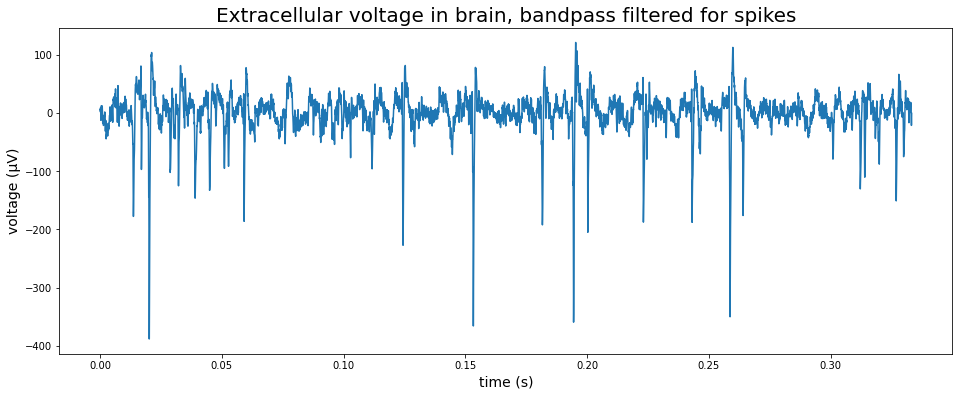

In [9]:
plt.figure(figsize=(16,6))
sample_rate = 30000
num_pts = 10000

x = np.arange(num_pts) / sample_rate
y = time_series_np[0:num_pts]

p = sns.lineplot(x=x, y=y, legend=False)
p.set_xlabel("time (s)", fontsize = 14)
p.set_ylabel("voltage (\u03BCV)", fontsize = 14)
p.set_title("Extracellular voltage in brain, bandpass filtered for spikes", fontsize = 20)

### We patch clamped to one of the neurons that was spiking in the above extracellular recording, so we have access to its intracellular (inside the neuron) voltage, which tells us when that neuron was spiking. Let's take a look at its extracellular voltage waveform, which we can determine by taking the average of the extracellular voltage around the times that the patched neuron spiked.

In [10]:
spike_info_path = 'data/spike_info.csv'
spike_info = pd.read_csv(spike_info_path, header=None)
spike_info_np = spike_info.to_numpy()
print('Done loading the spike times')

Done loading the spike times


(600,)


Text(0.5, 1.0, 'Mean extracellular voltage of a single neuron')

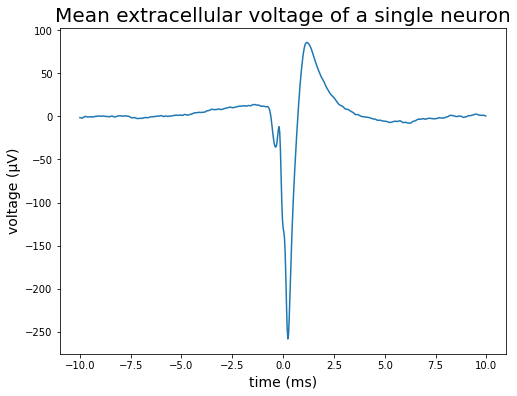

In [11]:
sample_rate = 30000.0 # Hz
total_samples = len(time_series_np)
total_t =  total_samples / sample_rate

# set the time range of the spike waveform to be 20ms

wfm_samples = int(np.round(sample_rate / 50))

wfm_array = np.zeros(wfm_samples)
count = 0

for idx, spike in enumerate(spike_info_np[:,1]): # Loop through all the spikes
    
    if (spike_info[1][idx] == -1) or (spike_info[1][idx] == 1): # We are only going to look at spikes that weren't part of a "burst" event
        t = spike_info[0][idx] # get the spike time
        sample = int(np.round(t * sample_rate))
        
        if sample > (wfm_samples / 2): # Edge condition: only get spikes that aren't cut off at the beginning of the recording
            
            if sample < (total_samples - wfm_samples / 2):  # Edge condition: only get spikes that aren't cut off at the end of the recording
                
                start_idx = int(np.round(sample - (wfm_samples / 2)))
                end_idx = int(np.round(sample + (wfm_samples / 2)))
    
                wfm_array = wfm_array + time_series_np[start_idx:end_idx]
                count += 1

wfm_kernel = wfm_array / count

plt.figure(figsize=(8,6))

wfm_x = (np.arange(wfm_samples)-wfm_samples/2)/sample_rate*1000
print(wfm_x.shape)
wfm_y = wfm_kernel

p_wfm = sns.lineplot(x=wfm_x, y=wfm_y, legend=False)

p_wfm.set_xlabel("time (ms)", fontsize = 14)
p_wfm.set_ylabel("voltage (\u03BCV)", fontsize = 14)
p_wfm.set_title("Mean extracellular voltage of a single neuron", fontsize = 20)